In [17]:
# Setup
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from pathlib import Path
from sklearn.linear_model import LogisticRegression

# Import custom methods
import sys
sys.path.append("../") # go to parent dir
from utilities import utilities as utils

# Ignore deprecation warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# Read in data, check formatting compatibility
pickle_path = Path('/Users/andreakeane/Documents/DataScience/GridCure_Problems/pickles/')
labels = pd.read_pickle(pickle_path / "labels.pkl")
X = pd.read_pickle(pickle_path / "X_all.pkl")
y = pd.read_pickle(pickle_path / "y_all.pkl")

if X.shape[0] != y.shape[0]: 
    # TODO: Raise Error
    print("ERROR. Dataframe shapes don't match.\n"
          "X Rows: {}"
          "y Rows: {}".format(X.shape, y.shape))

In [19]:
# Remove houses without EVs
houses_woEV = utils.get_pickle(pickle_path / "houses_woEV.pkl")
print("{} Houses without EVs".format(len(houses_woEV)))

y = y.drop(houses_woEV, errors='ignore')
X = X.drop(houses_woEV, errors='ignore')

print("Features:")
for feature in X.columns.tolist(): 
    print("  " + feature)

1105 Houses without EVs
Features:
	value
	diff
	h8_avg
	h24_avg
	h24_min
	h24_max
	h72_avg
	diff_2
	diff_3
	diff_5


In [20]:
# Scale and Split Training Data
X_train, X_test, y_train, y_test = utils.scale_split_data(X,y)

# Train logistic regression model
logreg = LogisticRegression(random_state=0)
logreg.fit(X_train, y_train)
print("Test Score: {:.3f}".format(logreg.score(X_test, y_test)))

# Generate results for test set
results = utils.generate_test_results(X_test, y_test, logreg)

Test Score: 0.946


In [21]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
y_true = results['label_true']
y_scores = results['label_prob']

# ROC
auc = roc_auc_score(y_true, y_scores)
print("ROC AUC Score: {:.3f}".format(auc))
fpr, tpr, thresholds_roc = roc_curve(y_true, y_scores)

# Precision-Recall (PR) Curve
ap = average_precision_score(y_true, y_scores)  
print("Average Precision Score: {:.3f}".format(ap))
p, r, thresholds_pr = precision_recall_curve(y_true, y_scores)



ROC AUC Score: 0.925
Average Precision Score: 0.624


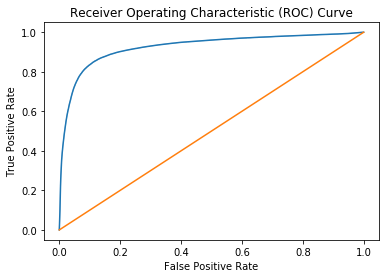

In [28]:
# Plot ROC Curve
sns.lineplot(x=fpr, y=tpr, markers='.')
sns.lineplot(x=[0,1], y=[0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

# fig.savefig(fig_path / "logreg_ROC.png")

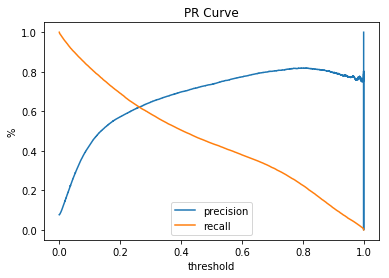

In [29]:
# Plot RP Curve
t = np.append(thresholds_pr, 1) 
if p.shape[0] != r.shape[0] != thresholds.shape[0]: 
    print("Error. Incorrect Shapes")
    print(p.shape[0], r.shape[0], t.shape[0])

sns.lineplot(t, p) 
sns.lineplot(t, r)
# sns.scatterplot(thresholds, queue_rate) 
leg = plt.legend(('precision', 'recall'), frameon=True) 
plt.xlabel('threshold') 
plt.ylabel('%')
plt.title('PR Curve');

# fig.savefig(fig_path / "logreg_PR.png")